In [1]:
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np
import networkx as nx
import nngt as nngt
#-->pip install powerlaw
import powerlaw

[WARNING @ nngt.generation.graph_connectivity]: from runpy.py (L194) - No module named 'nngt.generation.cconnect'
	Building module nngt.generation.cconnect failed: ["distutils.errors.CompileError: command 'clang' failed with exit status 1\n"]
	Cython import failed, using non-multithreaded algorithms.
[WARNING @ nngt.generation.graph_connectivity]: from runpy.py (L194) - Building module nngt.generation.cconnect failed: ["distutils.errors.CompileError: command 'clang' failed with exit status 1\n"]
	Building module nngt.generation.cconnect failed: ["distutils.errors.CompileError: command 'clang' failed with exit status 1\n"]
	Cython import failed, using non-multithreaded algorithms.


In [2]:
%matplotlib inline

In [3]:
#smoothing function, should be substituted by the log-binning later
def logAvDataExtrapolated(dist,M):
# data one dimentional
#gelogtExtra is extrapolated gelogt -
# for every i gelogtExtra(i) is an average of i/M points around i
#[s1, s2] = size(dataIn)
    dist = np.array (dist)
    sizedist = np.size(dist)
    gelogtExtra = np.zeros(sizedist)

    i = 0
    while np.ceil(i/M)<2:
        gelogtExtra[i]=dist[i]
        i = i+1
    while np.round(i+0.5* np.ceil(i/M)) < sizedist:
        i0 = int(np.round(i - 0.5 * np.ceil(i/M)))
        i1 = int(np.round(i + 0.5 * np.ceil(i/M)))
        gelogtExtra[i] = np.sum( dist[i0:i1]) / (i1-i0+1)
        i = i + 1
    return gelogtExtra

In [4]:
#computing surviving function
def CDFu(x,m):
    cdf = np.zeros(len(x)-m)
    for i in range(m,np.size(x)):
        cdf[i-m] = np.sum(x[i:])
    return cdf

#cutting the hairs

def DistCut(x,c):
    x = np.array(x)
    Cut = x[c:] / np.sum(x[c:] )
    return Cut

    #generate NIster iteration of subsampling of graph G of size NSize.
    # Sampling NSub nodes. return degree distribution
def ManySubsamplingDegree(G,NSize,NSub,NIter,cut):
    NumberOfnodes=0
    degree_freq_final = np.zeros(NSub)
    nodes = range (0, NSize)
    for i in range(NIter):
        permutenodes = np.random.permutation(nodes)
        Gsub = G.subgraph(permutenodes[0:NSub])
        degg= np.array(nx.degree_histogram(Gsub))
        degree_freq_final = degree_freq_final + np.pad(degg,(0,NSub - np.size(degg)),'constant')/NIter
        NumberOfnodes+= len([i for i in [val for (node, val) in Gsub.degree()] if i > cut])
    return degree_freq_final, NumberOfnodes/NIter

In [5]:
NSize = 100000
m = 14
G = nx.barabasi_albert_graph(NSize,m)
degree_freq = nx.degree_histogram(G)
degrees = range (len(degree_freq))

#Power law fitting to estimate k_min
fit = powerlaw.Fit([m for (l,m) in G.degree()], discrete=True)
k_min=int(fit.xmin)
alpha=fit.alpha

Calculating best minimal value for power law fit


In [6]:
NSub = 1000
NIter = 100
Nall= len([i for i in [val for (node, val) in G.degree()] if i > k_min])
degree_freq_sub_25,N25 = ManySubsamplingDegree(G,NSize,np.int(NSize/4),NIter,k_min)
degree_freq_sub_50,N50 = ManySubsamplingDegree(G,NSize,np.int(NSize/2),NIter,k_min)
degree_freq_sub_75,N75 = ManySubsamplingDegree(G,NSize,np.int(3*NSize/4),NIter,k_min)

In [7]:
degree_freq_sub_12,N12 = ManySubsamplingDegree(G,NSize,np.int(NSize/8),NIter,k_min)
degree_freq_sub_36,N36 = ManySubsamplingDegree(G,NSize,np.int(3*NSize/8),NIter,k_min)
degree_freq_sub_62,N62 = ManySubsamplingDegree(G,NSize,np.int(5*NSize/8),NIter,k_min)
degree_freq_sub_87,N87 = ManySubsamplingDegree(G,NSize,np.int(7*NSize/8),NIter,k_min)

In [8]:
degree_extrapolated = logAvDataExtrapolated(degree_freq,10)
degree_freq_sub_25_extr = logAvDataExtrapolated(degree_freq_sub_25,10)
degree_freq_sub_50_extr = logAvDataExtrapolated(degree_freq_sub_50,10)
degree_freq_sub_75_extr = logAvDataExtrapolated(degree_freq_sub_75,10)

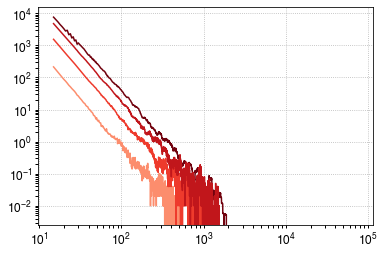

In [9]:
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 12})

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"
c4 = plt.cm.Reds(100)
c3 = plt.cm.Reds(160)
c2 = plt.cm.Reds(200)
c1 = plt.cm.Reds(250)

ctheor = 'gray'

cols = [c1, c4, c3, c2]



#plt.plot(degrees[m:],np.array(degree_freq[m:])/2.0,'go-')
m=15
plt.plot(np.arange(m,np.size(degree_extrapolated)),np.array(degree_extrapolated[m:]),color = cols[0])
plt.plot(np.arange(m,np.size(degree_freq_sub_25)),np.array(degree_freq_sub_25[m:]),color = cols[1])
plt.plot(np.arange(m,np.size(degree_freq_sub_50)),np.array(degree_freq_sub_50[m:]),color = cols[2])
plt.plot(np.arange(m,np.size(degree_freq_sub_75)),np.array(degree_freq_sub_75[m:]),color = cols[3])
plt.xscale('log')
plt.yscale('log')

xx = np.arange(1,NSize)
xxpower = np.power(xx,-3.0)
xxdist = xxpower/ sum(xxpower)

#plt.plot(xx,xxdist*(10**5)*10,'black')
#plt.savefig('scale-free_network_degree.pdf')

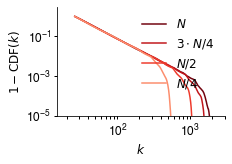

In [10]:
fig = plt.figure(figsize=(3,2))

plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 12})

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"
c4 = plt.cm.Reds(100)
c3 = plt.cm.Reds(160)
c2 = plt.cm.Reds(200)
c1 = plt.cm.Reds(250)

ctheor = 'gray'

cols = [c1, c2, c3, c4]

cut = k_min
degree_freq_cut_cdf = CDFu (DistCut (logAvDataExtrapolated(degree_freq,10),cut),0)
degree_freq_sub_25_cut_cdf = CDFu (DistCut( logAvDataExtrapolated(degree_freq_sub_25,10), cut),0)
degree_freq_sub_50_cut_cdf = CDFu (DistCut( logAvDataExtrapolated(degree_freq_sub_50,10), cut),0)
degree_freq_sub_75_cut_cdf = CDFu (DistCut( logAvDataExtrapolated(degree_freq_sub_75,10), cut),0)


ax = plt.subplot(111)
ax.plot(cut+np.arange(1,np.size(degree_freq_cut_cdf)+1),degree_freq_cut_cdf,color = cols[0],label=r'$N$')
ax.plot(cut + np.arange(1,np.size(degree_freq_sub_75_cut_cdf)+1), degree_freq_sub_75_cut_cdf,color = cols[1],label=r'$3 \cdot N/4$')
ax.plot(cut + np.arange(1,np.size(degree_freq_sub_50_cut_cdf)+1), degree_freq_sub_50_cut_cdf,color = cols[2],label=r'$N/2$')
ax.plot(cut + np.arange(1,np.size(degree_freq_sub_25_cut_cdf)+1), degree_freq_sub_25_cut_cdf,color = cols[3],label=r'$N/4$')



#handles, labels = ax.get_legend_handles_labels()
ax.legend( ncol=1, frameon =False, loc = 'upper right')

ax.set_xlim(15,3*10**3)
ax.set_ylim(10**(-5),3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$1 - \mathrm{CDF}(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)


plt.savefig('scale-free_network_CDF_unscaled.pdf',bbox_inches='tight')

In [11]:
#important to remember, that the number of Nodes is [NSize/4,NSize/2,NSize*3/2,NSize].
#However, the cumulative distribuion is built only considering those
#nodes with a degree > kmin. As a consequence of this, one should only consider as a number of nodes,
# number of nodes contribuiting in the cumulative distribution.



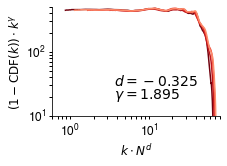

In [12]:
#Scaled plot
fig = plt.figure(figsize=(3,2))
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 14})

plt.rcParams["font.family"] = "Helvetica"
c4 = plt.cm.Reds(100)
c3 = plt.cm.Reds(160)
c2 = plt.cm.Reds(200)
c1 = plt.cm.Reds(250)

ctheor = 'gray'

cols = [c1, c2, c3, c4]

shift = 0
d = - 0.325
# in paper d = - 0.358
gamma = 1.895
#in paper gamma = 1.895
ax = plt.subplot(111)

ax.plot((cut +shift + np.arange(0,np.size(degree_freq_cut_cdf))) * (Nall**d),np.multiply(degree_freq_cut_cdf,np.arange(shift+cut,shift+cut+np.size(degree_freq_cut_cdf))**gamma),color = cols[0])
ax.plot((cut + shift + np.arange(0,np.size(degree_freq_sub_25_cut_cdf)))* ((N25)**d), np.multiply(degree_freq_sub_25_cut_cdf,np.arange(shift+cut,shift+cut+np.size(degree_freq_sub_25_cut_cdf))**gamma),color = cols[1])
ax.plot((cut  + shift + np.arange(0,np.size(degree_freq_sub_50_cut_cdf)))* ((N50)**d), np.multiply(degree_freq_sub_50_cut_cdf,np.arange(shift+cut,shift+cut+np.size(degree_freq_sub_50_cut_cdf))**gamma),color = cols[2])
ax.plot((cut + shift+ np.arange(0,np.size(degree_freq_sub_75_cut_cdf)))* ((N75)**d), np.multiply(degree_freq_sub_75_cut_cdf,np.arange(shift+cut,shift+cut+np.size(degree_freq_sub_75_cut_cdf))**gamma),color = cols[3])
ax.set_xlim(.6,80)
ax.set_ylim(10,5*10**2)
ax.set_xlabel(r'$k \cdot N^d$')
ax.set_ylabel(r'$(1 - \mathrm{CDF}(k)) \cdot k^\gamma$')
#ax.text(3.6, 18.6, r'$\gamma = $' + str(gamma),fontsize=14)
#ax.text(3.6, 29.6, r'$d =$ '+ str(d),fontsize=14)
ax.text(3.6, 18.6, r'$\gamma = 1.895$' ,fontsize=14)
ax.text(3.6, 29.6, r'$d = -0.325$ ',fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)

plt.savefig('scale-free_network_CDF_scaled.pdf',bbox_inches='tight')

## Subsampling scaling on the same data


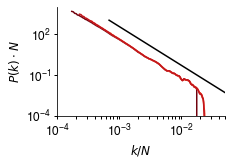

In [25]:
fig = plt.figure(figsize=(3,2))

plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 12})

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"
c5 = plt.cm.Reds(100)
c4 = plt.cm.Reds(100)
c3 = plt.cm.Reds(160)
c2 = plt.cm.Reds(200)
c1 = plt.cm.Reds(250)

ctheor = 'gray'

cols = [c1, c5, c4, c3, c2]

ax = plt.subplot(111)

#plt.plot(degrees[m:],np.array(degree_freq[m:])/2.0,'go-')
m=17
Mm = 4
ax.plot(np.arange(m,np.size(degree_extrapolated))/NSize,np.array(logAvDataExtrapolated(degree_extrapolated[1:],Mm))[m-1:],color = cols[0])
#ax.plot(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),np.array(degree_freq_sub_25[m:]),color = cols[1])
#ax.plot(np.arange(m,np.size(degree_freq_sub_12))/(NSize/8),np.array(logAvDataExtrapolated(degree_freq_sub_12[1:],Mm))[m-1:],color = cols[1])
ax.plot(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),np.array(logAvDataExtrapolated(degree_freq_sub_25[1:],Mm))[m-1:],color = cols[2])
ax.plot(np.arange(m,np.size(degree_freq_sub_50))/(NSize/2),np.array(logAvDataExtrapolated(degree_freq_sub_50[1:],Mm))[m-1:],color = cols[3])
ax.plot(np.arange(m,np.size(degree_freq_sub_75))/(3*NSize/4),np.array(logAvDataExtrapolated(degree_freq_sub_75[1:],Mm))[m-1:],color = cols[4])

ax.plot(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),np.power(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),-2.85)/ 1000000,color = 'black')

ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
ax.set_xlim(10**(-4),0.05)
ax.set_ylim(10**(-4),10**4)
ax.set_xlabel(r'$k / N $')
ax.set_ylabel(r'$P(k) \cdot N$')

xx = np.arange(1,NSize)
xxpower = np.power(xx,-2.85)
xxdist = xxpower/ sum(xxpower)
#ax.plot(xx/10**4,xxdist* 10**5,'--', color = 'gray')
plt.savefig('scale-free_network_PDF_scaled.pdf',bbox_inches='tight')

In [18]:
print (np.power(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),-3)[0:5]* 1000)

[3.18033788e+12 2.67918381e+12 2.27802887e+12 1.95312500e+12
 1.68718281e+12]


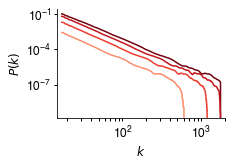

In [15]:
fig = plt.figure(figsize=(3,2))

plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 12})

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"
c5 = plt.cm.Reds(100)
c4 = plt.cm.Reds(100)
c3 = plt.cm.Reds(160)
c2 = plt.cm.Reds(200)
c1 = plt.cm.Reds(250)

ctheor = 'gray'

cols = [c1, c5, c4, c3, c2]

ax = plt.subplot(111)

#plt.plot(degrees[m:],np.array(degree_freq[m:])/2.0,'go-')
m=17
Mm = 4
CNorm = np.sum(np.array(logAvDataExtrapolated(degree_extrapolated[1:],Mm))[m-1:])

ax.plot(np.arange(m,np.size(degree_extrapolated)),np.array(logAvDataExtrapolated(degree_extrapolated[1:],Mm))[m-1:]/CNorm,color = cols[0])
#ax.plot(np.arange(m,np.size(degree_freq_sub_25))/(NSize/4),np.array(degree_freq_sub_25[m:]),color = cols[1])
#ax.plot(np.arange(m,np.size(degree_freq_sub_12))/(NSize/8),np.array(logAvDataExtrapolated(degree_freq_sub_12[1:],Mm))[m-1:],color = cols[1])
ax.plot(np.arange(m,np.size(degree_freq_sub_25)),np.array(logAvDataExtrapolated(degree_freq_sub_25[1:],Mm))[m-1:]/CNorm,color = cols[2])
ax.plot(np.arange(m,np.size(degree_freq_sub_50)),np.array(logAvDataExtrapolated(degree_freq_sub_50[1:],Mm))[m-1:]/CNorm,color = cols[3])
ax.plot(np.arange(m,np.size(degree_freq_sub_75)),np.array(logAvDataExtrapolated(degree_freq_sub_75[1:],Mm))[m-1:]/CNorm,color = cols[4])

ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
ax.set_xlim(m-2,2* 10**3)
#ax.set_ylim(10**(-2),10**4)
ax.set_xlabel(r'$k $')
ax.set_ylabel(r'$P(k)$')

#plt.plot(xx,xxdist*(10**5)*10,'black')
plt.savefig('scale-free_network_PDF_unscaled_new.pdf',bbox_inches='tight')